# This project has taken several turns. The addition of census data led to time-consuming cleanup and too many potential issues of poor data quality. I found it best to stick to the GTD as the primary source of data, so I needed to find a valid and useful question based solely on the information provided in the GTD.

# As it happens, I'm highly interested in NLP applications and decided this would be a good fit. The GTD contains a feature 'motive', which provides a string of variable length describing the perceived motive of an attacker if it is known. 

# The GTD also contains a feature 'success', a binary indicator of whether an attack was successful or not according to the tangible effects. 

# Naturally, the proper goal of incident preparedness is to limit successful attacks as much as possible. To aid in this effort, my model will do the following:

# 1) Receive a potential motive for an attack written by the user.
# 2) Run an NLP analysis of that motive as a feature along with the following variables: target type, attack type, weapon type, weekday/weekend, number of fatalities, number wounded.
# 3) These features will be used to predict the target variable: success.
# 4) Return the circumstances of the most probable successful attacks given the motive.

# Example: User inputs the following as as a motive:
## "Political extremist group desires to protest government initiative to allow a democratic vote instead of the traditional parliamentary appointment."

# And the model returns: 
## Chance of successful attack given the following parameters: 0.81
## Target Type: 'Governmental Building'
## Attack Type: 'Bombing/Explosion'
## Weapon Type: 'Incindiary'
## Projected Fatality Count: 5-10
## Projected Wounded Count: 5-15

# Notebooks 3.1 (this one) and 3.2 contain everything from loading to preprocessing in light of this new model. EDA is relatively sparse but can be seen in greater detail in previous notebooks.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
file_path = r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\raw\globalterrorismdb_0522dist.xlsx'
file_path2 = r"C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\raw\globalterrorismdb_2021Jan-June_1222dist.xlsx"


In [8]:
df1 = pd.read_excel(file_path)
df2 = pd.read_excel(file_path2)

KeyboardInterrupt: 

In [9]:
df = pd.concat([df1, df2], join='outer', ignore_index=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214666 entries, 0 to 214665
Columns: 135 entries, eventid to related
dtypes: datetime64[ns](1), float64(54), int64(23), object(57)
memory usage: 221.1+ MB
None


In [40]:
dft = df[['eventid','iyear','imonth','iday','latitude','longitude','country_txt','region','city','provstate',\
          'success','targtype1_txt','targsubtype1_txt','attacktype1_txt','weaptype1_txt','nkill','nwound','nkillter',\
          'nperps','propextent_txt','motive','addnotes','gname','corp1','related','INT_LOG','INT_IDEO']]
print(dft.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214666 entries, 0 to 214665
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   eventid           214666 non-null  int64  
 1   iyear             214666 non-null  int64  
 2   imonth            214666 non-null  int64  
 3   iday              214666 non-null  int64  
 4   latitude          209940 non-null  float64
 5   longitude         209939 non-null  float64
 6   country_txt       214666 non-null  object 
 7   region            214666 non-null  int64  
 8   city              214239 non-null  object 
 9   provstate         214666 non-null  object 
 10  success           214666 non-null  int64  
 11  targtype1_txt     214666 non-null  object 
 12  targsubtype1_txt  202644 non-null  object 
 13  attacktype1_txt   214666 non-null  object 
 14  weaptype1_txt     214666 non-null  object 
 15  nkill             201715 non-null  float64
 16  nwound            19

In [41]:
nullmask = dft['motive'].isna()
dfn = dft[~nullmask]
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55796 entries, 5 to 214653
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   eventid           55796 non-null  int64  
 1   iyear             55796 non-null  int64  
 2   imonth            55796 non-null  int64  
 3   iday              55796 non-null  int64  
 4   latitude          55244 non-null  float64
 5   longitude         55244 non-null  float64
 6   country_txt       55796 non-null  object 
 7   region            55796 non-null  int64  
 8   city              55369 non-null  object 
 9   provstate         55796 non-null  object 
 10  success           55796 non-null  int64  
 11  targtype1_txt     55796 non-null  object 
 12  targsubtype1_txt  53413 non-null  object 
 13  attacktype1_txt   55796 non-null  object 
 14  weaptype1_txt     55796 non-null  object 
 15  nkill             54268 non-null  float64
 16  nwound            52293 non-null  float64
 1

In [42]:
dfn.describe()

,eventid,iyear,imonth,iday,latitude,longitude,region,success,nkill,nwound,nkillter,nperps,INT_LOG,INT_IDEO
count,5.579600e+04,55796.000000,55796.000000,55796.000000,55244.000000,55244.000000,55796.000000,55796.000000,54268.000000,52293.000000,54374.000000,42774.000000,55796.000000,55796.000000
mean,2.009016e+11,2008.950122,6.432522,15.305076,25.873878,47.150442,7.518048,0.914187,2.761296,4.835102,0.275040,-69.048628,-4.822084,-4.751541
std,7.015507e+08,7.015608,3.381920,8.822414,14.598519,47.968960,2.618644,0.280090,16.525286,71.757507,3.918293,67.267519,4.532704,4.617745
min,1.970010e+11,1970.000000,1.000000,0.000000,-84.671596,-157.858333,1.000000,0.000000,0.000000,0.000000,0.000000,-99.000000,-9.000000,-9.000000
25%,2.006041e+11,2006.000000,4.000000,8.000000,14.543970,34.327161,6.000000,1.000000,0.000000,0.000000,0.000000,-99.000000,-9.000000,-9.000000
50%,2.009120e+11,2009.000000,6.000000,15.000000,31.825871,44.921905,6.000000,1.000000,0.000000,0.000000,0.000000,-99.000000,-9.000000,-9.000000
75%,2.013091e+11,2013.000000,9.000000,23.000000,34.516895,75.165839,10.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000
max,2.021063e+11,2021.000000,12.000000,31.000000,74.633553,179.366667,12.000000,1.000000,1700.000000,10878.000000,500.000000,5000.000000,1.000000,1.000000


In [43]:
dfknown = dfn.loc[(dfn['targtype1_txt'] != 'Unknown') & (dfn['attacktype1_txt'] != 'Unknown')\
                 & (dfn.motive != 'Unknown') & (dfn.motive != 'The specific motive for the attack is unknown.') \
                  & (dfn.motive != 'The specific motive for the attack is unknown..')\
                 & (dfn.motive != 'The specific motive for the attack is unknown or was not reported.')]
print(dfknown.info())
dfknown.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 24971 entries, 5 to 214653
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   eventid           24971 non-null  int64  
 1   iyear             24971 non-null  int64  
 2   imonth            24971 non-null  int64  
 3   iday              24971 non-null  int64  
 4   latitude          24738 non-null  float64
 5   longitude         24738 non-null  float64
 6   country_txt       24971 non-null  object 
 7   region            24971 non-null  int64  
 8   city              24939 non-null  object 
 9   provstate         24971 non-null  object 
 10  success           24971 non-null  int64  
 11  targtype1_txt     24971 non-null  object 
 12  targsubtype1_txt  24531 non-null  object 
 13  attacktype1_txt   24971 non-null  object 
 14  weaptype1_txt     24971 non-null  object 
 15  nkill             23835 non-null  float64
 16  nwound            22936 non-null  float64
 1

,eventid,iyear,imonth,iday,latitude,longitude,region,success,nkill,nwound,nkillter,nperps,INT_LOG,INT_IDEO
count,2.497100e+04,24971.000000,24971.000000,24971.000000,24738.000000,24738.000000,24971.000000,24971.000000,23835.000000,22936.000000,24586.000000,23049.000000,24971.000000,24971.000000
mean,2.011555e+11,2011.489968,6.356213,15.182412,24.569816,42.635573,7.334708,0.911377,2.925656,4.000087,0.317091,-67.052497,-3.629370,-3.524809
std,8.642299e+08,8.642219,3.435803,8.820436,15.312932,54.464006,2.869631,0.284204,18.743167,18.489092,4.005000,72.855899,4.473903,4.568990
min,1.970010e+11,1970.000000,1.000000,0.000000,-84.671596,-157.818968,1.000000,0.000000,0.000000,0.000000,0.000000,-99.000000,-9.000000,-9.000000
25%,2.010021e+11,2010.000000,3.000000,8.000000,12.884646,20.151145,6.000000,1.000000,0.000000,0.000000,0.000000,-99.000000,-9.000000,-9.000000
50%,2.013121e+11,2013.000000,6.000000,15.000000,28.583333,44.584493,6.000000,1.000000,0.000000,0.000000,0.000000,-99.000000,0.000000,0.000000
75%,2.017032e+11,2017.000000,9.000000,23.000000,34.416159,80.830373,10.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,2.021063e+11,2021.000000,12.000000,31.000000,64.547251,179.366667,12.000000,1.000000,1700.000000,1001.000000,346.000000,5000.000000,1.000000,1.000000


<Axes: >

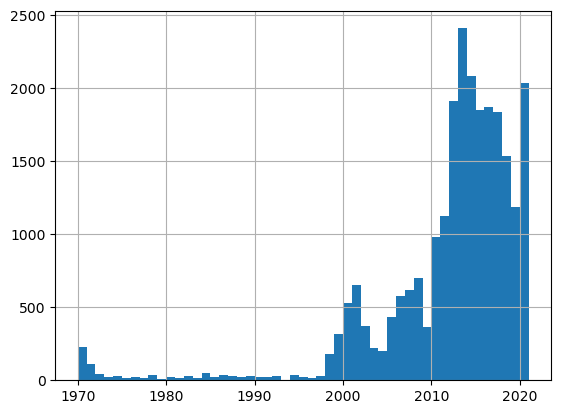

In [44]:
dfknown.iyear.hist(bins=2021-1970)

<Axes: ylabel='count'>

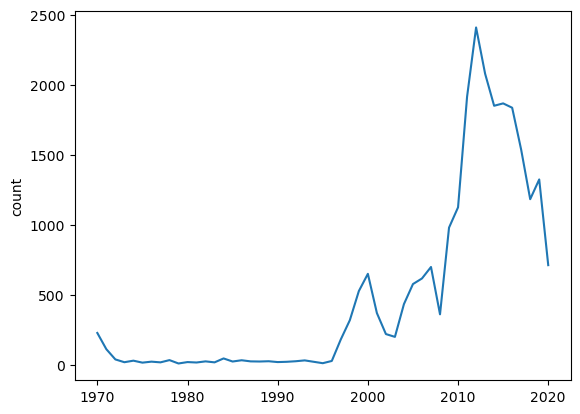

In [45]:
xval = range(1970, 2021)
yval = dfknown.iyear.value_counts().sort_index()

sns.lineplot(x = xval, y = yval)

(24971, 27)
(23995, 27)


<Axes: ylabel='count'>

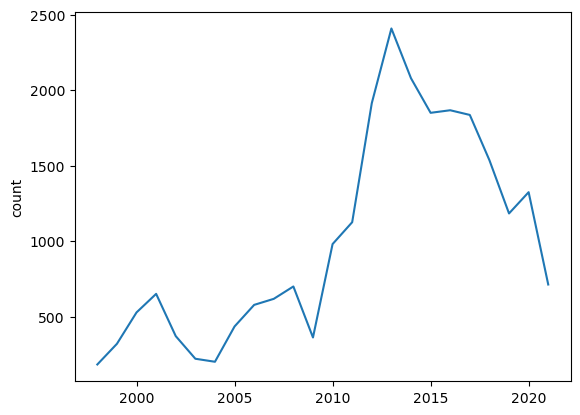

In [46]:
df98 = dfknown.loc[df['iyear'] >= 1998,:]
print(dfknown.shape)
print(df98.shape)
xval = range(1998, 2022)
yval = df98.iyear.value_counts().sort_index()
sns.lineplot(x = xval, y = yval)

In [81]:
dfknown = df98

In [82]:
for x in dfknown.weaptype1_txt:
    if x == "Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)" :
        dfknown.weaptype1_txt = dfknown.weaptype1_txt.str.replace("Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)","Vehicle")
dfknown.weaptype1_txt.unique()

C:\Users\casti\AppData\Local\Temp\ipykernel_20592\2497625733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfknown.weaptype1_txt = dfknown.weaptype1_txt.str.replace("Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)","Vehicle")


array(['Explosives', 'Firearms', 'Incendiary', 'Fake Weapons', 'Chemical',
       'Melee', 'Unknown', 'Other', 'Sabotage Equipment', 'Biological',
       'Radiological', 'Vehicle'], dtype=object)

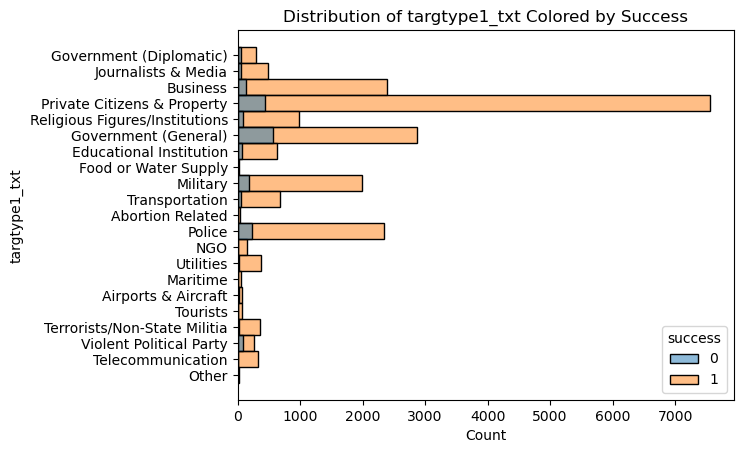

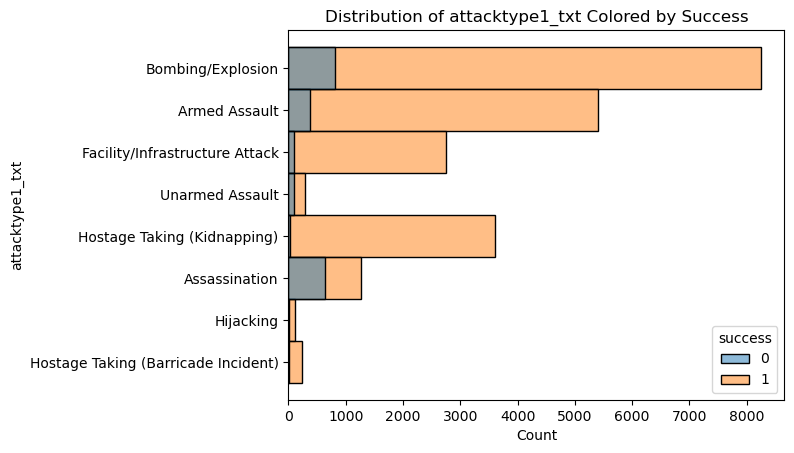

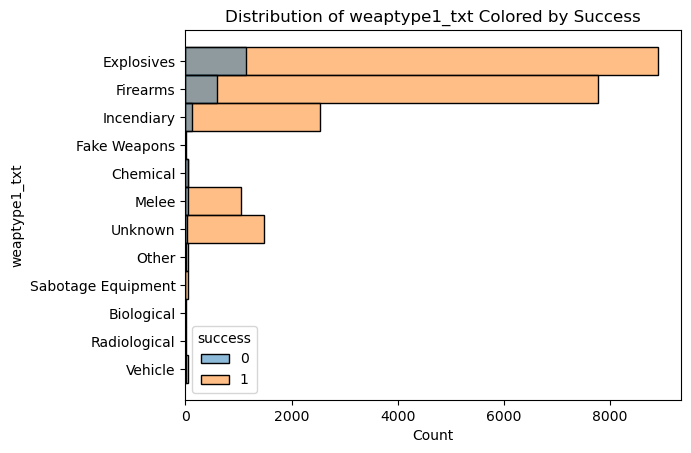

In [22]:
for x in ['targtype1_txt','attacktype1_txt','weaptype1_txt']:
    sns.histplot(y=dfknown[x], hue=dfknown.success)
    plt.title(f'Distribution of {x} Colored by Success')
    plt.show();


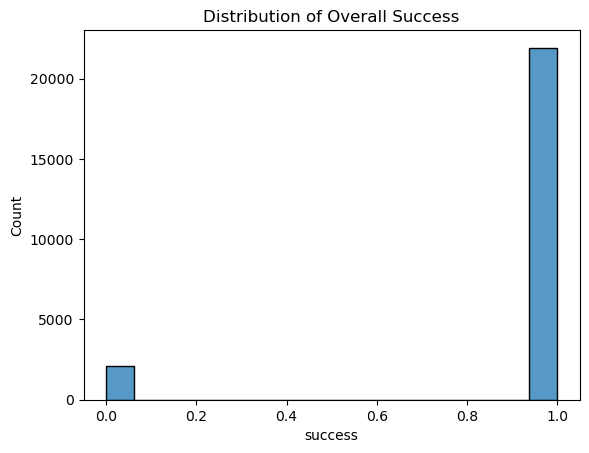

In [23]:
sns.histplot(dfknown.success)
plt.title('Distribution of Overall Success')
plt.show();

In [33]:
dfknown.nkill.fillna(0, inplace=True)
dfknown.nwound.fillna(0, inplace=True)

fatalities_cat
0       12764
1-5      8837
5-14     1522
15+       872
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Fatalities')

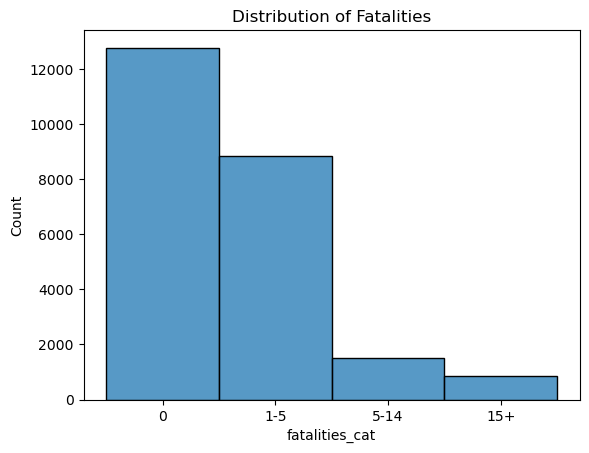

In [34]:
ranges = [-1, 0.5, 5.5, 14.5, float('inf')] 
labels = ['0', '1-5', '5-14', '15+']
dfknown['fatalities_cat'] = pd.cut(dfknown['nkill'], bins=ranges, labels=labels, right=False)
print(dfknown.fatalities_cat.value_counts())
sns.histplot(dfknown.fatalities_cat)
plt.title('Distribution of Fatalities')

wound_cat
0        15531
1-5       5350
5-14      1713
15-29      757
30+        644
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Wounded')

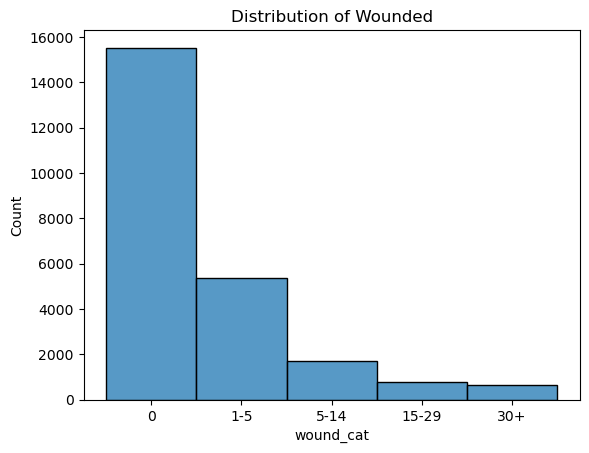

In [35]:
ranges = [-1, 0.5, 5.5, 14.5, 29.5, float('inf')] 
labels = ['0', '1-5', '5-14', '15-29', '30+']
dfknown['wound_cat'] = pd.cut(dfknown['nwound'], bins=ranges, labels=labels, right=False)
print(dfknown.wound_cat.value_counts())
sns.histplot(dfknown.wound_cat)
plt.title('Distribution of Wounded')

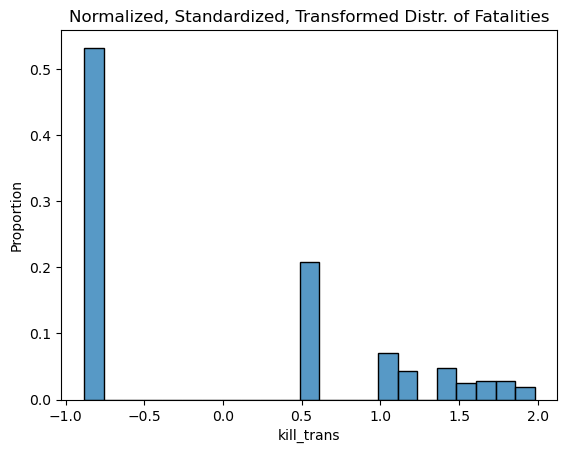

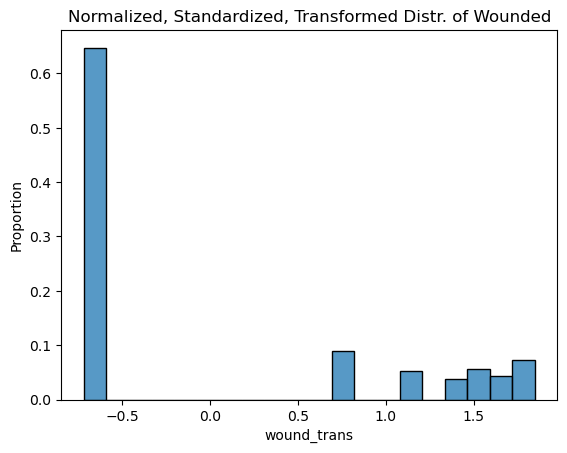

In [36]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
pt.fit(np.array(dfknown.nkill).reshape(-1,1))
dfknown['kill_trans'] = pt.transform(np.array(dfknown.nkill).reshape(-1,1))
sns.histplot(dfknown.kill_trans, stat='proportion')
plt.title('Normalized, Standardized, Transformed Distr. of Fatalities')
plt.show();

pt = PowerTransformer()
pt.fit(np.array(dfknown.nwound).reshape(-1,1))
dfknown['wound_trans'] = pt.transform(np.array(dfknown.nwound).reshape(-1,1))
plt.title('Normalized, Standardized, Transformed Distr. of Wounded')
sns.histplot(dfknown.wound_trans, stat='proportion')
plt.show();

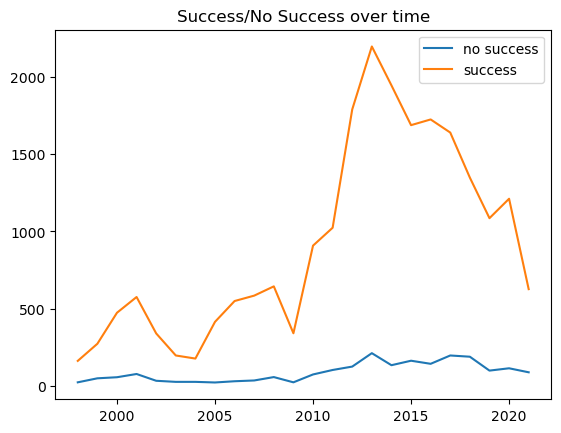

In [37]:
success_counts = dfknown.groupby('success')['iyear'].value_counts().sort_index()

plt.plot(success_counts[0], label='no success')
plt.plot(success_counts[1], label='success')
plt.legend()
plt.title('Success/No Success over time')
plt.show();

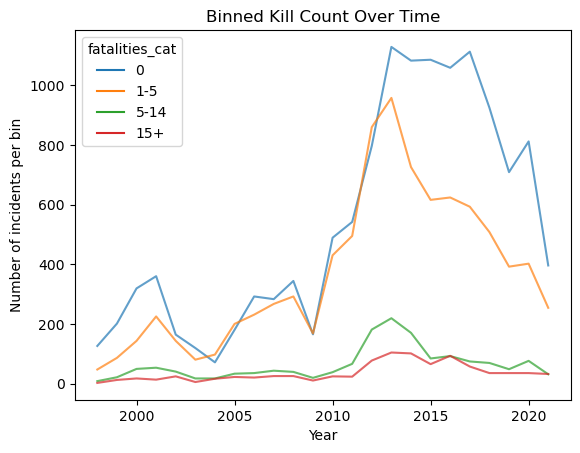

In [38]:
kill_counts = dfknown.groupby('iyear')['fatalities_cat'].value_counts()

df_kill_counts = kill_counts.reset_index(name='count')
sns.lineplot(data=df_kill_counts, x='iyear', y='count', hue='fatalities_cat', alpha = 0.7)

plt.xlabel('Year')
plt.ylabel('Number of incidents per bin')
plt.title('Binned Kill Count Over Time')

plt.show()

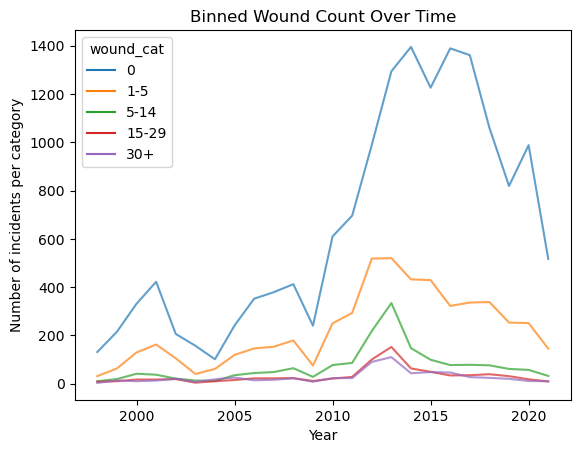

In [39]:
wound_counts = dfknown.groupby('iyear')['wound_cat'].value_counts()

df_wound_counts = wound_counts.reset_index(name='count')
sns.lineplot(data=df_wound_counts, x='iyear', y='count', hue='wound_cat', alpha = 0.7)

plt.xlabel('Year')
plt.ylabel('Number of incidents per category')
plt.title('Binned Wound Count Over Time')

plt.show()

In [40]:
#dfknown.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfknown.csv')

In [41]:
#dfknown = pd.read_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfknown.csv')

In [42]:
dfknown.shape

(23995, 32)

In [43]:
# from sklearn.preprocessing import QuantileTransformer

# qt = QuantileTransformer(output_distribution='normal')
# qt.fit(np.array(dfknown.nkill).reshape(-1,1))
# dfknown['kill_transqt'] = qt.transform(np.array(dfknown.nkill).reshape(-1,1))
# sns.histplot(dfknown.kill_transqt, stat='proportion')
# plt.title('Normalized, Standardized, Transformed Distr. of Fatalities')
# plt.show();

In [48]:
import datetime
dfknown['iday'].replace({0: 15}, inplace=True)
dfknown['date'] = dfknown.apply(lambda row: datetime.datetime(row['iyear'], row['imonth'], row['iday']), axis=1)

In [88]:
# Make a new df just to finish out preprocessing steps. Consolidate strictly to features of interest: date, Motive, success, nkill, nwound, targtype, weaptype, attacktype.
dfpr = dfknown[['date','latitude','longitude','motive','targtype1_txt','weaptype1_txt','attacktype1_txt','kill_trans','wound_trans','fatalities_cat','wound_cat','success']]
dfpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23995 entries, 0 to 23994
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             23995 non-null  datetime64[ns]
 1   latitude         23764 non-null  float64       
 2   longitude        23764 non-null  float64       
 3   motive           23995 non-null  object        
 4   targtype1_txt    23995 non-null  object        
 5   weaptype1_txt    23995 non-null  object        
 6   attacktype1_txt  23995 non-null  object        
 7   kill_trans       23995 non-null  float64       
 8   wound_trans      23995 non-null  float64       
 9   fatalities_cat   23995 non-null  category      
 10  wound_cat        23995 non-null  category      
 11  success          23995 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 1.9+ MB


# From here: bag variables into most popular and 'other', encode variables, run nlp on motive, perhaps perform pca? and split training/testing

In [90]:
print('value counts before bagging target types')
print(dfpr.targtype1_txt.value_counts())
targ_mask = dfpr.targtype1_txt.value_counts() > 200
for idx, val in dfpr.targtype1_txt.items():
    if targ_mask[val] == False:
        dfpr.loc[idx, 'targtype1_txt'] = 'Other'
print('\n')
print('value counts after bagging target types')
print(dfpr.targtype1_txt.value_counts())

value counts before bagging target types
targtype1_txt
Private Citizens & Property       7991
Government (General)              3430
Police                            2563
Business                          2522
Military                          2168
Religious Figures/Institutions    1060
Transportation                     731
Educational Institution            709
Journalists & Media                534
Utilities                          392
Terrorists/Non-State Militia       366
Government (Diplomatic)            361
Violent Political Party            341
Telecommunication                  336
NGO                                154
Airports & Aircraft                103
Tourists                            79
Maritime                            50
Abortion Related                    40
Food or Water Supply                35
Other                               30
Name: count, dtype: int64


value counts after bagging target types
targtype1_txt
Private Citizens & Property       7991
Gover

In [91]:
import re

for idx, val in dfpr.attacktype1_txt.items():
    if re.search(r'\bHostage\b', val):
        dfpr.loc[idx, 'attacktype1_txt'] = 'Hostage Taking'

In [92]:
print('value counts before bagging attack types')
print(dfpr.attacktype1_txt.value_counts())
attack_mask = dfpr.attacktype1_txt.value_counts() > 1000
for idx, val in dfpr.attacktype1_txt.items():
    if attack_mask[val] == False:
        dfpr.loc[idx, 'attacktype1_txt'] = 'Other'
print('\n')
print('value counts after bagging target types')
print(dfpr.attacktype1_txt.value_counts())

value counts before bagging attack types
attacktype1_txt
Bombing/Explosion                 9065
Armed Assault                     5772
Hostage Taking                    3879
Facility/Infrastructure Attack    2861
Assassination                     1907
Unarmed Assault                    390
Hijacking                          121
Name: count, dtype: int64


value counts after bagging target types
attacktype1_txt
Bombing/Explosion                 9065
Armed Assault                     5772
Hostage Taking                    3879
Facility/Infrastructure Attack    2861
Assassination                     1907
Other                              511
Name: count, dtype: int64


In [93]:
dfpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23995 entries, 0 to 23994
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             23995 non-null  datetime64[ns]
 1   latitude         23764 non-null  float64       
 2   longitude        23764 non-null  float64       
 3   motive           23995 non-null  object        
 4   targtype1_txt    23995 non-null  object        
 5   weaptype1_txt    23995 non-null  object        
 6   attacktype1_txt  23995 non-null  object        
 7   kill_trans       23995 non-null  float64       
 8   wound_trans      23995 non-null  float64       
 9   fatalities_cat   23995 non-null  category      
 10  wound_cat        23995 non-null  category      
 11  success          23995 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 1.9+ MB


In [96]:
dfpr.dropna(inplace=True)

C:\Users\casti\AppData\Local\Temp\ipykernel_23484\2855094157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpr.dropna(inplace=True)


In [97]:
dfpr.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfpr.csv')

# Further preprocessing steps will take place in notebook 3.2.